#### This script will explore the isotopic variation among samples that are near to one another -- then plot these relationships. 
By: Amanda Worthy

In [40]:
#import packages
from shapely.geometry import shape
#import rasterstats
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from shapely.geometry.point import Point
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import fiona
import pyproj
import os
import requests
import matplotlib.ticker as ticker
from rasterio.enums import Resampling
from affine import Affine
import shapely.geometry
import pyproj
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
import time
from itertools import combinations
import plotly.express as px
import pandas as pd
import rasterio
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import geopandas as gpd
import rioxarray


In [41]:
#import the USA file 
usa_fxn = "usa.geojson"

usa = gpd.read_file(usa_fxn)

In [42]:
!ls

Modeling_w_spatial_cv.ipynb
Newest_dataset_analysis_python.ipynb
Tree_ds_sep16.csv
environment.yml
explore_variation_among_same_location.ipynb
spatial_auto_tests.ipynb
usa.geojson


In [43]:
#import the tree dataset 
tree_fxn = "Tree_ds_sep16.csv"

tree= pd.read_csv(tree_fxn)

tree['Latitude_short'] = tree['Latitude'].round(4) # round so that we can find duplicates

tree['Longitude_short'] = tree['Longitude'].round(4) # round so that we can find duplicates

mygeometry_array = gpd.points_from_xy(tree['Longitude_short'], tree['Latitude_short'])

tree= gpd.GeoDataFrame(
tree, crs='EPSG:4326', geometry=mygeometry_array)


tree = tree[~tree['Region'].isin(['California', 'Washington'])]  # get them out!!! 


In [44]:
#how many tree locats are unique? 
tree.geometry.nunique()

67

In [49]:
# group by lat and long (to 4 decimals) 
grouped = tree.groupby('geometry')

counts = grouped.size().reset_index(name='tree_count_at_locat')

counts.tree_count_at_locat.unique()

counts

,geometry,tree_count_at_locat
0,POINT (-90.8383 32.1152),2
1,POINT (-90.8411 32.1228),1
2,POINT (-84.4749 36.1775),3
3,POINT (-84.291 36.1531),1
4,POINT (-81.4924 38.1395),1
...,...,...
62,POINT (-69.5375 44.1009),2
63,POINT (-69.4956 44.0558),1
64,POINT (-69.4963 44.0523),1
65,POINT (-71.714 42.9551),2


In [50]:

# Group by geometry and count trees at each location
counts = tree.groupby('geometry').size().reset_index(name='tree_count_at_locat')

# Filter geometries with more than 1 tree
counts_multi = counts[counts['tree_count_at_locat'] > 1].copy()
counts_multi['duplicate_id'] = range(1, len(counts_multi) + 1)

#add the duplicate count column to tree 
tree = tree.merge(counts_multi[['geometry', 'duplicate_id','tree_count_at_locat' ]], on='geometry', how='left')

#make a dataframe of only duplicate counts 
tree_2 = tree[tree['tree_count_at_locat'] > 1]

tree_2.head()



,tree_id,Region,Latitude,Longitude,geometry,Species,Date collected,Type of sample,Height of sample,Diameter of tree at sample location (inches),...,12_tmin_nClimGrid,annual_tmin_nClimGrid,Latitude_short,Longitude_short,duplicate_id_x,tree_count_at_locat_x,duplicate_id_y,tree_count_at_locat_y,duplicate_id,tree_count_at_locat
6,6,New Hampshire,42.955077,-71.713975,POINT (-71.714 42.9551),alba,22/03/19,disk,NaN,13.0,...,-6.511361,2.457287,42.9551,-71.7140,8.0,2.0,8.0,2.0,8.0,2.0
7,7,New Hampshire,42.955077,-71.713975,POINT (-71.714 42.9551),rubra,22/03/19,disk,NaN,14.0,...,-6.511361,2.457287,42.9551,-71.7140,8.0,2.0,8.0,2.0,8.0,2.0
9,9,Maryland,39.509911,-78.936803,POINT (-78.9368 39.5099),alba,13/07/18,core,4.0,12.7,...,-3.605892,5.151850,39.5099,-78.9368,4.0,2.0,4.0,2.0,4.0,2.0
10,10,Maryland,39.509920,-78.936755,POINT (-78.9368 39.5099),alba,13/07/18,core,4.0,5.2,...,-3.605892,5.151850,39.5099,-78.9368,4.0,2.0,4.0,2.0,4.0,2.0
15,15,Vermont,43.686360,-72.309677,POINT (-72.3097 43.6864),rubra,14/04/19,core,NaN,12.5,...,-8.086589,1.253125,43.6864,-72.3097,6.0,3.0,6.0,3.0,6.0,3.0


In [54]:
# find out when these duplicates came from 

tree["duplicate"] = tree["tree_count_at_locat"].apply(lambda x: "yes" if x > 1 else "no")

tree["Date collected"] = pd.to_datetime(tree["Date collected"], errors="coerce")

tree = tree.sort_values(by="Date collected")

tree.tail(5)


tree['year'] = (tree["Date collected"].dt.year)

tree.head(5)

#of the 17 samples taken after 2017 (in 2018 or 2019) 7 are duplicate samples 

,tree_id,Region,Latitude,Longitude,geometry,Species,Date collected,Type of sample,Height of sample,Diameter of tree at sample location (inches),...,Latitude_short,Longitude_short,duplicate_id_x,tree_count_at_locat_x,duplicate_id_y,tree_count_at_locat_y,duplicate_id,tree_count_at_locat,duplicate,year
0,0,Ohio,41.486318,-81.934554,POINT (-81.9346 41.4863),rubra,2017-01-07,disk,NaN,27.5,...,41.4863,-81.9346,NaN,NaN,NaN,NaN,NaN,NaN,no,2017
18,18,Ohio,41.076832,-81.811698,POINT (-81.8117 41.0768),rubra / falcata,2017-07-05,disk,NaN,10.0,...,41.0768,-81.8117,NaN,NaN,NaN,NaN,NaN,NaN,no,2017
25,25,Pennsylvania,41.471338,-79.267316,POINT (-79.2673 41.4713),alba,2017-08-01,disk,NaN,9.0,...,41.4713,-79.2673,NaN,NaN,NaN,NaN,NaN,NaN,no,2017
26,26,Pennsylvania,41.973179,-78.271318,POINT (-78.2713 41.9732),alba,2017-08-02,disk,NaN,10.0,...,41.9732,-78.2713,NaN,NaN,NaN,NaN,NaN,NaN,no,2017
21,21,New York,42.290338,-77.096754,POINT (-77.0968 42.2903),sp.,2017-08-03,disk,NaN,9.0,...,42.2903,-77.0968,NaN,NaN,NaN,NaN,NaN,NaN,no,2017


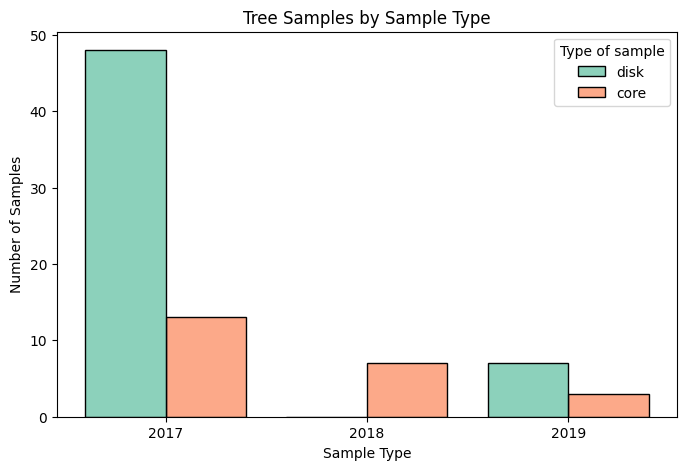

In [55]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=tree,
    x="year",
    hue="Type of sample",
    multiple="dodge",    
    discrete=True,       
    shrink=0.8,         
    palette="Set2"
)

plt.title("Tree Samples by Sample Type")
plt.xlabel("Sample Type")
plt.ylabel("Number of Samples")
plt.xticks([2017, 2018, 2019])

plt.show()


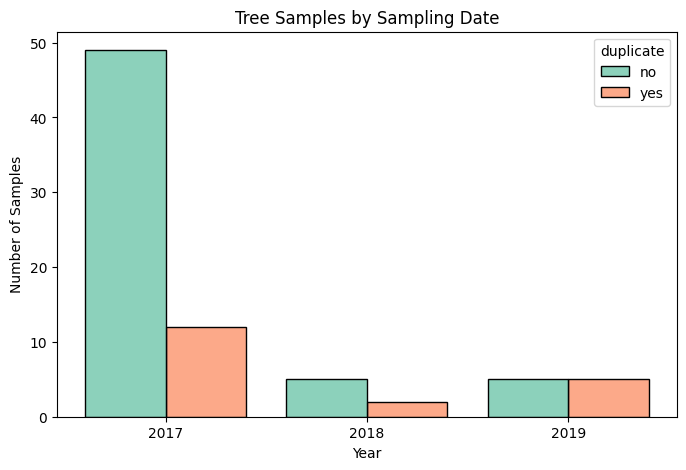

In [56]:

plt.figure(figsize=(8, 5))
sns.histplot(
    data=tree,
    x="year",
    hue="duplicate",
    multiple="dodge",    
    discrete=True,       
    shrink=0.8,          
    palette="Set2"
)

plt.title("Tree Samples by Sampling Date")
plt.xlabel("Year")
plt.ylabel("Number of Samples")
plt.xticks([2017, 2018, 2019])

plt.show()


In [38]:
# Filter samples after 2017
late_tree = tree[tree["Date collected"].dt.year > 2017].copy()

late_tree

,tree_id,Region,Latitude,Longitude,geometry,Species,Date collected,Type of sample,Height of sample,Diameter of tree at sample location (inches),...,10_tmin_nClimGrid,11_tmin_nClimGrid,12_tmin_nClimGrid,annual_tmin_nClimGrid,Latitude_short,Longitude_short,duplicate_id,tree_count_at_locat,duplicate,year
8,8,Virginia,36.679900,-78.345948,POINT (-78.3459 36.6799),alba,2018-06-26,core,NaN,5.2,...,8.202246,2.749967,-0.526009,8.473606,36.6799,-78.3459,NaN,NaN,no,2018
14,14,Maryland,39.509886,-78.937028,POINT (-78.937 39.5099),alba,2018-07-13,core,4.0,9.1,...,5.734343,0.692643,-3.605892,5.151850,39.5099,-78.9370,NaN,NaN,no,2018
13,13,Maryland,39.510046,-78.937171,POINT (-78.9372 39.51),alba,2018-07-13,core,4.0,4.4,...,5.734343,0.692643,-3.605892,5.151850,39.5100,-78.9372,NaN,NaN,no,2018
12,12,Maryland,39.510834,-78.936741,POINT (-78.9367 39.5108),alba,2018-07-13,core,4.0,5.0,...,5.734343,0.692643,-3.605892,5.151850,39.5108,-78.9367,NaN,NaN,no,2018
11,11,Maryland,39.510365,-78.937235,POINT (-78.9372 39.5104),alba,2018-07-13,core,4.0,6.7,...,5.734343,0.692643,-3.605892,5.151850,39.5104,-78.9372,NaN,NaN,no,2018
10,10,Maryland,39.509920,-78.936755,POINT (-78.9368 39.5099),alba,2018-07-13,core,4.0,5.2,...,5.734343,0.692643,-3.605892,5.151850,39.5099,-78.9368,4.0,2.0,yes,2018
9,9,Maryland,39.509911,-78.936803,POINT (-78.9368 39.5099),alba,2018-07-13,core,4.0,12.7,...,5.734343,0.692643,-3.605892,5.151850,39.5099,-78.9368,4.0,2.0,yes,2018
2,2,Pennsylvania,40.573010,-75.339340,POINT (-75.3393 40.573),alba,2019-01-16,disk,NaN,9.0,...,5.415690,0.469401,-3.621094,5.051194,40.5730,-75.3393,NaN,NaN,no,2019
3,3,Pennsylvania,41.195420,-75.856400,POINT (-75.8564 41.1954),alba,2019-01-19,disk,NaN,8.0,...,3.801302,-1.403646,-5.992969,2.602510,41.1954,-75.8564,NaN,NaN,no,2019
5,5,Michigan,44.536360,-84.670510,POINT (-84.6705 44.5364),alba,2019-03-20,disk,6.0,16.0,...,2.712012,-2.461263,-7.330469,0.867638,44.5364,-84.6705,NaN,NaN,no,2019


Text(0.5, 1.0, 'Tree Samples After 2018 by duplicate')

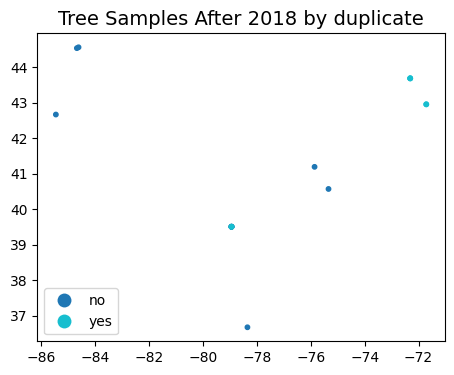

In [58]:
fig, ax = plt.subplots(figsize=(8, 4))
#usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
late_tree.plot(column='duplicate', cmap= 'tab10',  legend=True, ax=ax, s=10);

ax.set_title("Tree Samples After 2018 by duplicate", fontsize=14)


# we have figured out that the late sampling campaign was not only for duplicates and that every tree is unique 

In [81]:
tree_grouped_summary = tree_2.groupby('duplicate_id').agg({
    'd18O': [
        'mean',
        'min',
        'max',
        lambda x: x.max() - x.min(),
        lambda x: abs((x.max() - x.min()) / x.mean()) * 100,
        
    ],
    'd2H': [
        'mean',
        'min',
        'max',
        lambda x: x.max() - x.min(),
        lambda x: abs((x.max() - x.min()) / x.mean()) * 100
    ],
    'd13C': [
        'mean',
        'min',
        'max',
        lambda x: x.max() - x.min(),
        lambda x: abs((x.max() - x.min()) / x.mean()) * 100
    ],
    'd34S': [
        'mean',
        'min',
        'max',
        lambda x: x.max() - x.min(),
        lambda x: abs((x.max() - x.min()) / x.mean()) * 100
    ],
}).reset_index()

# Flatten column names
tree_grouped_summary.columns = [
    '_'.join([col[0], col[1]])
     .strip('_')
    .replace('<lambda_0>', 'range')
    .replace('<lambda_1>', 'pct_diff')
   # .replace('_first', '')
    for col in tree_grouped_summary.columns
]

tree_grouped_summary.head(3)


,duplicate_id,d18O_mean,d18O_min,d18O_max,d18O_range,d18O_pct_diff,d2H_mean,d2H_min,d2H_max,d2H_range,...,d13C_mean,d13C_min,d13C_max,d13C_range,d13C_pct_diff,d34S_mean,d34S_min,d34S_max,d34S_range,d34S_pct_diff
0,1.0,26.20,25.6,26.8,1.2,4.580153,-70.75,-71.3,-70.2,1.1,...,-29.200000,-29.5,-28.9,0.6,2.054795,2.800000,2.8,2.8,0.0,0.000000
1,2.0,25.10,24.6,25.4,0.8,3.187251,-82.20,-85.1,-80.6,4.5,...,-27.566667,-27.8,-27.3,0.5,1.813785,2.466667,1.8,3.2,1.4,56.756757
2,3.0,25.35,25.3,25.4,0.1,0.394477,-88.65,-92.2,-85.1,7.1,...,-27.750000,-27.8,-27.7,0.1,0.360360,-0.900000,-1.8,0.0,1.8,200.000000


In [62]:
#merge w duplicate dataframe 

tree_3 = tree_2.merge(
    tree_grouped_summary, 
    on='duplicate_id', 
    how='left'
)

tree_3


,tree_id,Region,Latitude,Longitude,geometry,Species,Date collected,Type of sample,Height of sample,Diameter of tree at sample location (inches),...,d13C_mean,d13C_min,d13C_max,d13C_range,d13C_pct_diff,d34S_mean,d34S_min,d34S_max,d34S_range,d34S_pct_diff
0,6,New Hampshire,42.955077,-71.713975,POINT (-71.714 42.9551),alba,22/03/19,disk,NaN,13.0,...,-26.850000,-27.2,-26.5,0.7,2.607076,1.950000,1.3,2.6,1.3,66.666667
1,7,New Hampshire,42.955077,-71.713975,POINT (-71.714 42.9551),rubra,22/03/19,disk,NaN,14.0,...,-26.850000,-27.2,-26.5,0.7,2.607076,1.950000,1.3,2.6,1.3,66.666667
2,9,Maryland,39.509911,-78.936803,POINT (-78.9368 39.5099),alba,13/07/18,core,4.0,12.7,...,-25.600000,-25.8,-25.4,0.4,1.562500,-0.450000,-1.1,0.2,1.3,288.888889
3,10,Maryland,39.509920,-78.936755,POINT (-78.9368 39.5099),alba,13/07/18,core,4.0,5.2,...,-25.600000,-25.8,-25.4,0.4,1.562500,-0.450000,-1.1,0.2,1.3,288.888889
4,15,Vermont,43.686360,-72.309677,POINT (-72.3097 43.6864),rubra,14/04/19,core,NaN,12.5,...,-25.100000,-25.4,-24.7,0.7,2.788845,2.333333,2.1,2.5,0.4,17.142857
5,16,Vermont,43.686360,-72.309677,POINT (-72.3097 43.6864),rubra,14/04/19,core,NaN,12.5,...,-25.100000,-25.4,-24.7,0.7,2.788845,2.333333,2.1,2.5,0.4,17.142857
6,17,Vermont,43.686360,-72.309677,POINT (-72.3097 43.6864),rubra,14/04/19,core,NaN,11.5,...,-25.100000,-25.4,-24.7,0.7,2.788845,2.333333,2.1,2.5,0.4,17.142857
7,22,Mississippi,32.115214,-90.838293,POINT (-90.8383 32.1152),alba,8/5/17,disk,NaN,6.7,...,-29.200000,-29.5,-28.9,0.6,2.054795,2.800000,2.8,2.8,0.0,0.000000
8,23,Mississippi,32.115214,-90.838293,POINT (-90.8383 32.1152),michauxii,8/5/17,disk,NaN,7.5,...,-29.200000,-29.5,-28.9,0.6,2.054795,2.800000,2.8,2.8,0.0,0.000000
9,52,Pennsylvania,41.361880,-76.659500,POINT (-76.6595 41.3619),alba,10/3/17,disk,NaN,10.0,...,-26.533333,-26.9,-25.9,1.0,3.768844,1.966667,1.6,2.2,0.6,30.508475


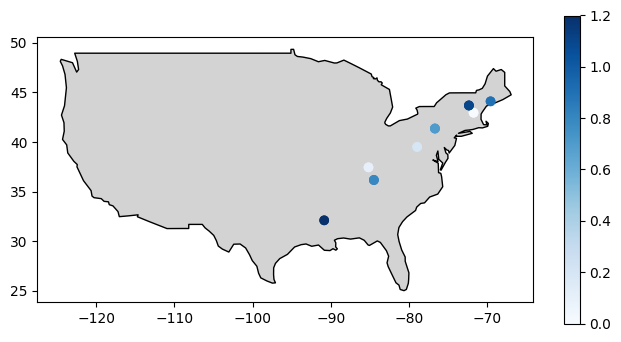

In [63]:
fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax = ax, color = 'lightgray', edgecolor = 'black')
tree_3.plot(column='d18O_range', cmap= 'Blues',  legend=True, ax=ax);


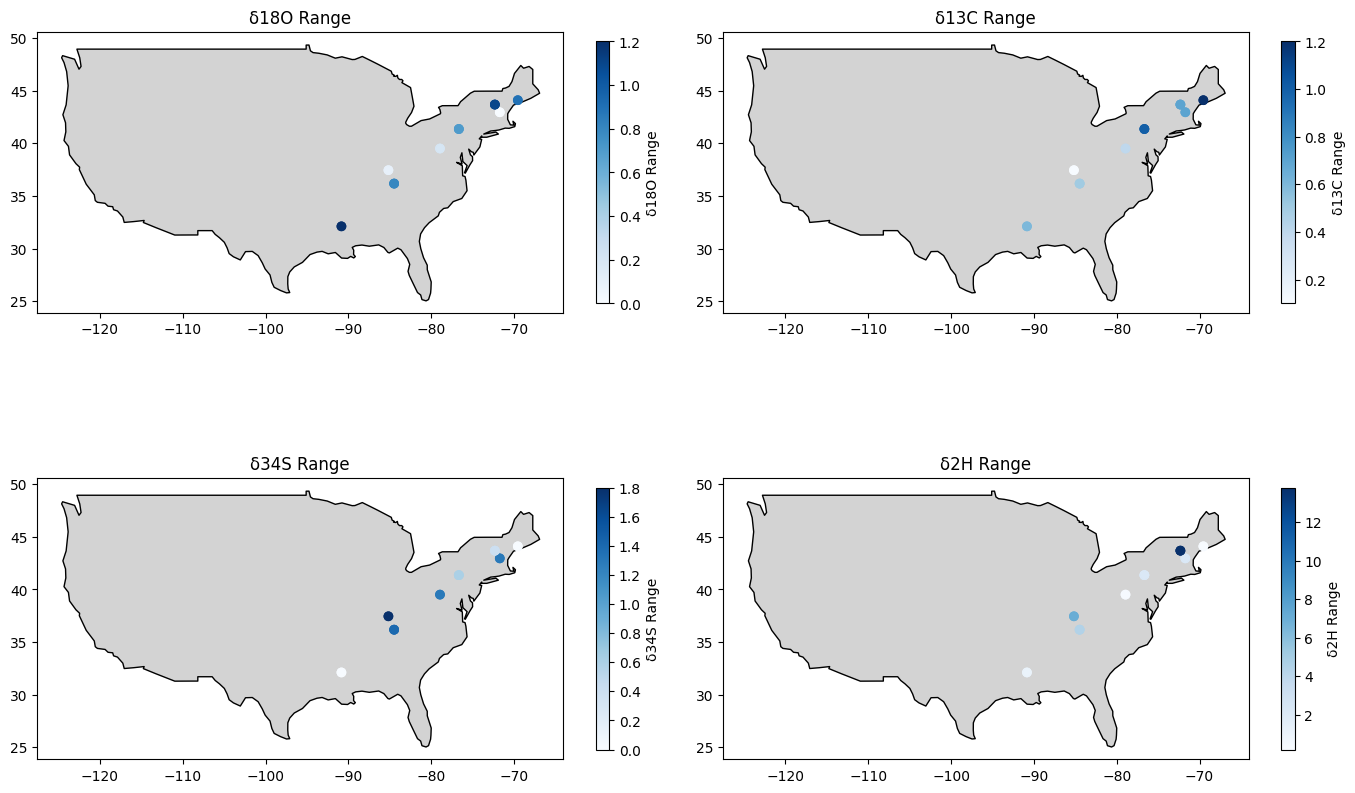

In [68]:

# List of isotope ranges and titles
ranges = [
    ("d18O_range", "δ18O Range"),
    ("d13C_range", "δ13C Range"),
    ("d34S_range", "δ34S Range"),
    ("d2H_range",  "δ2H Range")
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

for ax, (col, title) in zip(axes, ranges):
    usa.plot(ax=ax, color='lightgray', edgecolor='black')
    tree_3.plot(
        column=col,
        cmap='Blues',
        legend=True,
        ax=ax,
        legend_kwds={
            "label": title,
            "shrink": 0.5
        }
    )
    ax.set_title(title)

plt.tight_layout()
plt.show()


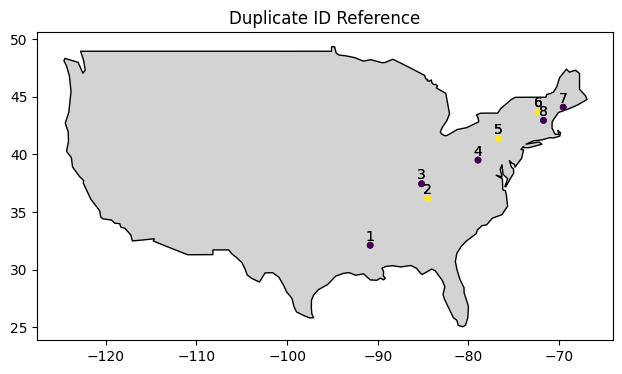

In [69]:
fig, ax = plt.subplots(figsize=(8, 4))
usa.plot(ax=ax, color='lightgray', edgecolor='black')

tree_3.plot(column='tree_count_at_locat', markersize=15, legend=False, ax=ax,)

# add labels 
for idx, row in tree_3.iterrows():
    ax.text(
        row.geometry.representative_point().x, 
        row.geometry.representative_point().y +0.4, 
        str(int(row['duplicate_id'])),
        fontsize=10,
        ha='center',
        color='black'
    )

ax.set_title("Duplicate ID Reference")
plt.show()


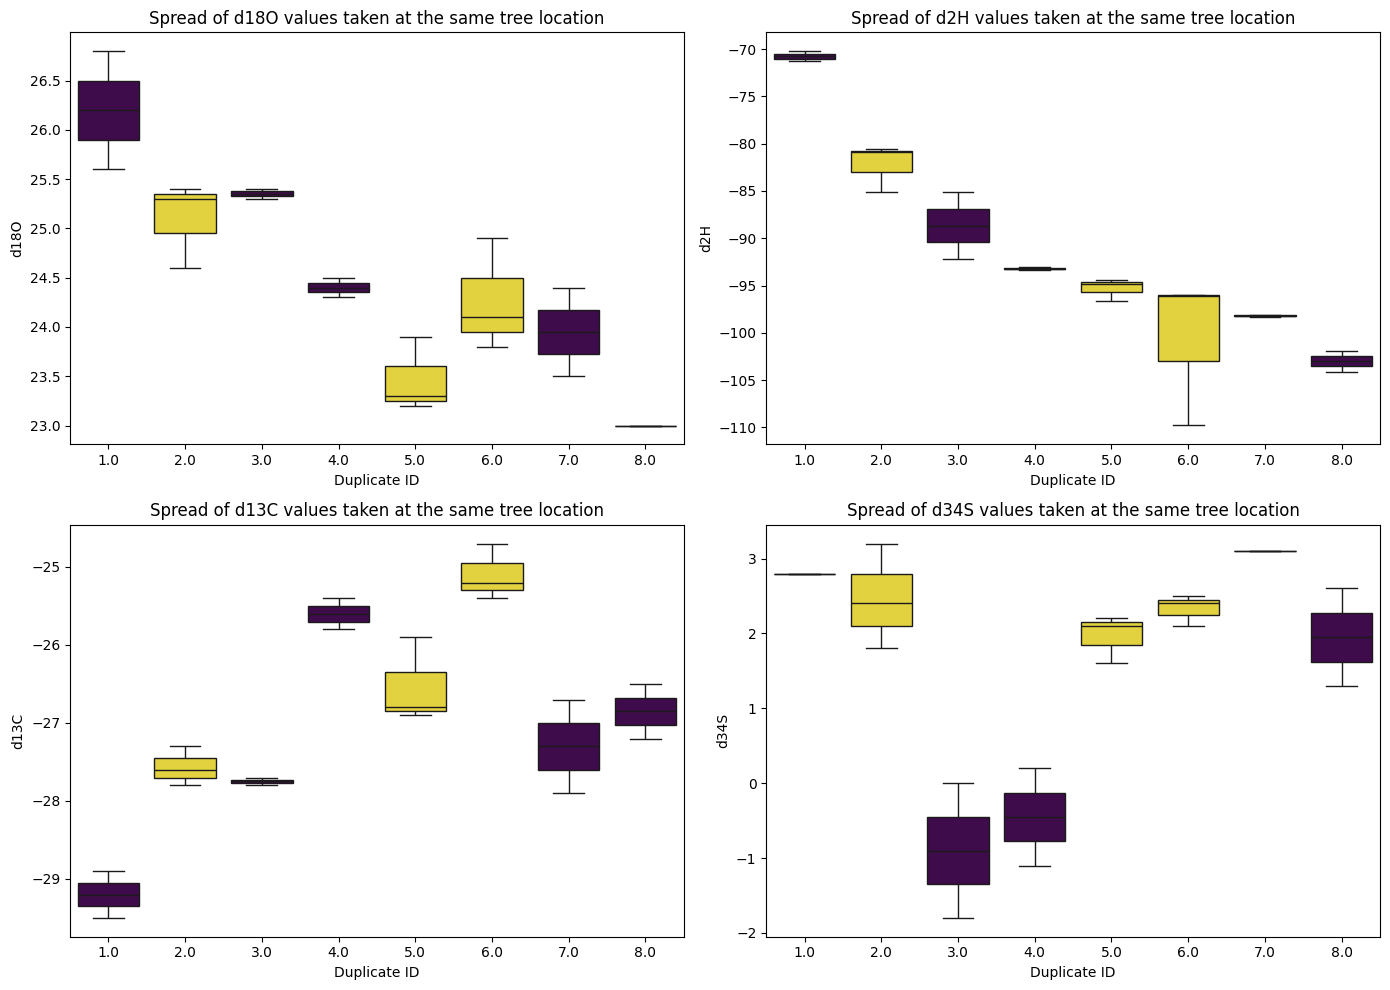

In [88]:
# Columns to plot
cols = ['d18O', 'd2H', 'd13C', 'd34S']

# Set up a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(
        data=tree_3,
        x='duplicate_id',
        y=col,
        hue='tree_count_at_locat',
        ax=axes[i],
       # dodge=False,  # prevents boxes from splitting by hue
        palette='viridis', 
        legend= False
    )
    axes[i].set_title(f'Spread of {col} values taken at the same tree location')
    axes[i].set_xlabel('Duplicate ID')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


In [70]:

tree_3["Date collected"] = pd.to_datetime(tree_3["Date collected"], errors="coerce")

tree_3['year']= tree_3['Date collected'].dt.year

tree_3

/var/folders/yw/51w3wvb97794y1f596f8yf440000gn/T/ipykernel_45101/440841432.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tree_3["Date collected"] = pd.to_datetime(tree_3["Date collected"], errors="coerce")


,tree_id,Region,Latitude,Longitude,geometry,Species,Date collected,Type of sample,Height of sample,Diameter of tree at sample location (inches),...,d13C_min,d13C_max,d13C_range,d13C_pct_diff,d34S_mean,d34S_min,d34S_max,d34S_range,d34S_pct_diff,year
0,6,New Hampshire,42.955077,-71.713975,POINT (-71.714 42.9551),alba,2019-03-22,disk,NaN,13.0,...,-27.2,-26.5,0.7,2.607076,1.950000,1.3,2.6,1.3,66.666667,2019
1,7,New Hampshire,42.955077,-71.713975,POINT (-71.714 42.9551),rubra,2019-03-22,disk,NaN,14.0,...,-27.2,-26.5,0.7,2.607076,1.950000,1.3,2.6,1.3,66.666667,2019
2,9,Maryland,39.509911,-78.936803,POINT (-78.9368 39.5099),alba,2018-07-13,core,4.0,12.7,...,-25.8,-25.4,0.4,1.562500,-0.450000,-1.1,0.2,1.3,288.888889,2018
3,10,Maryland,39.509920,-78.936755,POINT (-78.9368 39.5099),alba,2018-07-13,core,4.0,5.2,...,-25.8,-25.4,0.4,1.562500,-0.450000,-1.1,0.2,1.3,288.888889,2018
4,15,Vermont,43.686360,-72.309677,POINT (-72.3097 43.6864),rubra,2019-04-14,core,NaN,12.5,...,-25.4,-24.7,0.7,2.788845,2.333333,2.1,2.5,0.4,17.142857,2019
5,16,Vermont,43.686360,-72.309677,POINT (-72.3097 43.6864),rubra,2019-04-14,core,NaN,12.5,...,-25.4,-24.7,0.7,2.788845,2.333333,2.1,2.5,0.4,17.142857,2019
6,17,Vermont,43.686360,-72.309677,POINT (-72.3097 43.6864),rubra,2019-04-14,core,NaN,11.5,...,-25.4,-24.7,0.7,2.788845,2.333333,2.1,2.5,0.4,17.142857,2019
7,22,Mississippi,32.115214,-90.838293,POINT (-90.8383 32.1152),alba,2017-08-05,disk,NaN,6.7,...,-29.5,-28.9,0.6,2.054795,2.800000,2.8,2.8,0.0,0.000000,2017
8,23,Mississippi,32.115214,-90.838293,POINT (-90.8383 32.1152),michauxii,2017-08-05,disk,NaN,7.5,...,-29.5,-28.9,0.6,2.054795,2.800000,2.8,2.8,0.0,0.000000,2017
9,52,Pennsylvania,41.361880,-76.659500,POINT (-76.6595 41.3619),alba,2017-10-03,disk,NaN,10.0,...,-26.9,-25.9,1.0,3.768844,1.966667,1.6,2.2,0.6,30.508475,2017


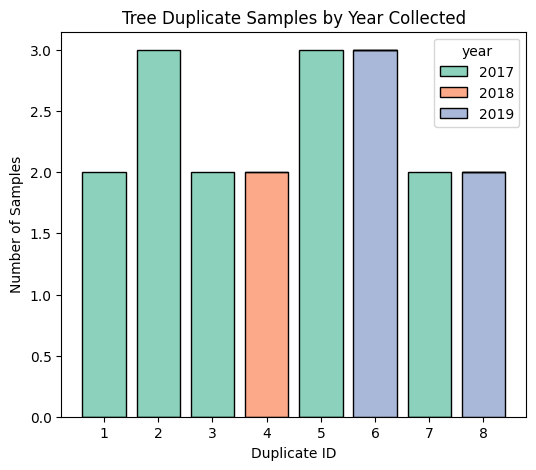

In [71]:
plt.figure(figsize=(6, 5))
sns.histplot(
    data=tree_3,
    x="duplicate_id",
    hue="year",
    multiple="stack",    
    discrete=True,      
    shrink=0.8,         
    palette="Set2"
)

plt.title("Tree Duplicate Samples by Year Collected")
plt.xlabel("Duplicate ID")
plt.ylabel("Number of Samples")


plt.show()


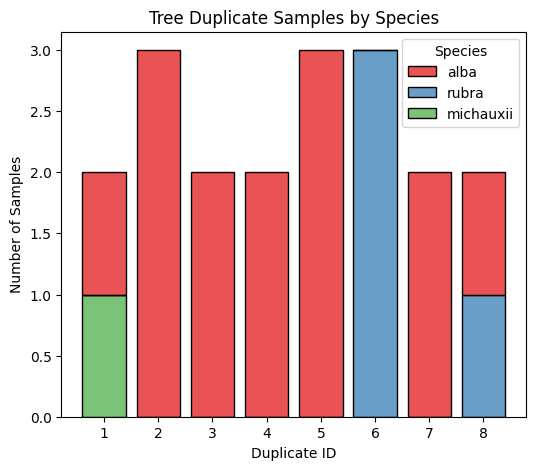

In [72]:
plt.figure(figsize=(6, 5))
sns.histplot(
    data=tree_3,
    x="duplicate_id",
    hue="Species",
    multiple="stack",   
    discrete=True,       
    shrink=0.8,         
    palette="Set1"
)

plt.title("Tree Duplicate Samples by Species")
plt.xlabel("Duplicate ID")
plt.ylabel("Number of Samples")


plt.show()


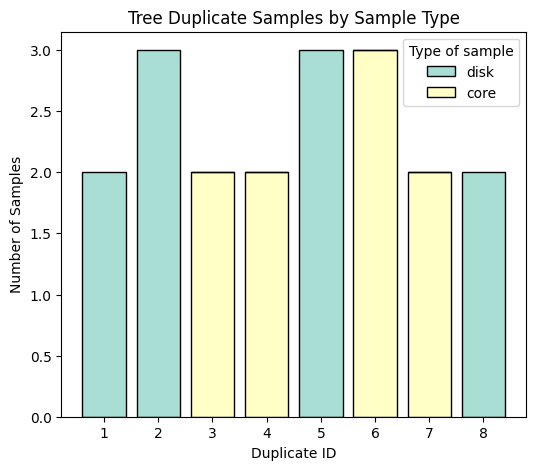

In [73]:
plt.figure(figsize=(6, 5))
sns.histplot(
    data=tree_3,
    x="duplicate_id",
    hue="Type of sample",
    multiple="stack",    
    discrete=True,       
    shrink=0.8,         
    palette="Set3"
)

plt.title("Tree Duplicate Samples by Sample Type")
plt.xlabel("Duplicate ID")
plt.ylabel("Number of Samples")


plt.show()


In [74]:
tree_grouped_summary.columns

Index(['duplicate_id', 'd18O_mean', 'd18O_min', 'd18O_max', 'd18O_range',
       'd18O_pct_diff', 'd2H_mean', 'd2H_min', 'd2H_max', 'd2H_range',
       'd2H_pct_diff', 'd13C_mean', 'd13C_min', 'd13C_max', 'd13C_range',
       'd13C_pct_diff', 'd34S_mean', 'd34S_min', 'd34S_max', 'd34S_range',
       'd34S_pct_diff'],
      dtype='object')

In [82]:
# create a df of only range cols and convert from wide to long 

range_cols = [col for col in tree_grouped_summary.columns if '_range' in col]
cols_to_keep = ['duplicate_id'] + range_cols
df_range = tree_grouped_summary[cols_to_keep]

df_long = df_range.melt(
    id_vars=['duplicate_id'], 
    value_vars=range_cols, 
    var_name='Isotope', 
    value_name='Range'
)

df_long['Isotope'] = df_long['Isotope'].str.replace('_range', '')

df_long


,duplicate_id,Isotope,Range
0,1.0,d18O,1.2
1,2.0,d18O,0.8
2,3.0,d18O,0.1
3,4.0,d18O,0.2
4,5.0,d18O,0.7
5,6.0,d18O,1.1
6,7.0,d18O,0.9
7,8.0,d18O,0.0
8,1.0,d2H,1.1
9,2.0,d2H,4.5


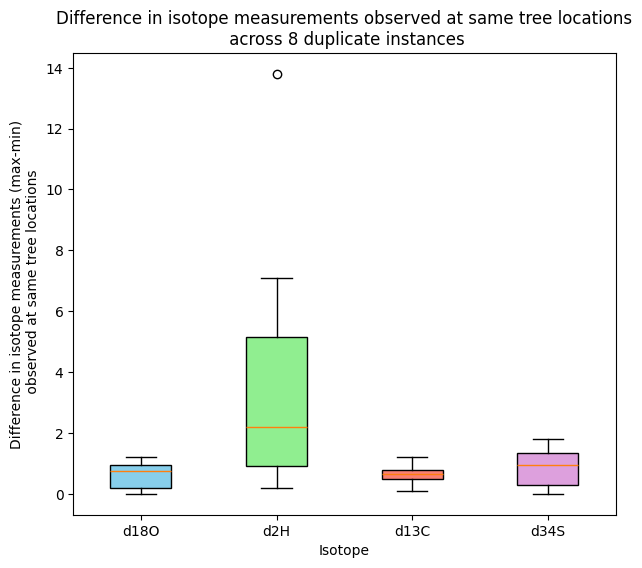

In [102]:
isotopes = df_long['Isotope'].unique()
data_to_plot = [df_long[df_long['Isotope'] == iso]['Range'].values for iso in isotopes]

# Create boxplot
fig, ax = plt.subplots(figsize=(7, 6))
box = ax.boxplot(data_to_plot, patch_artist=True)

# Color each box differently
colors = ['skyblue', 'lightgreen', 'salmon', 'plum']  
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set x-axis labels
ax.set_xticklabels(isotopes)
ax.grid(False)
ax.set_xlabel("Isotope")
ax.set_title("Difference in isotope measurements observed at same tree locations\n across 8 duplicate instances")
ax.set_ylabel("Difference in isotope measurements (max-min)\n observed at same tree locations")

plt.show()


In [84]:
#now a precent dif plot but remove sulphur bc its bunk 

diff_cols = [col for col in tree_grouped_summary.columns if 'diff' in col]
cols_to_keep = ['duplicate_id'] + diff_cols
df_diff = tree_grouped_summary[cols_to_keep]

df_long_d = df_diff.melt(
    id_vars=['duplicate_id'], 
    value_vars=diff_cols, 
    var_name='Isotope', 
    value_name='Range'
)


df_long_d['Isotope'] = df_long_d['Isotope'].str.replace('_pct_diff', '')

df_long_d = df_long_d[df_long_d["Isotope"] != "d34S"]

df_long_d



,duplicate_id,Isotope,Range
0,1.0,d18O,4.580153
1,2.0,d18O,3.187251
2,3.0,d18O,0.394477
3,4.0,d18O,0.819672
4,5.0,d18O,2.982955
5,6.0,d18O,4.532967
6,7.0,d18O,3.757829
7,8.0,d18O,0.000000
8,1.0,d2H,1.554770
9,2.0,d2H,5.474453


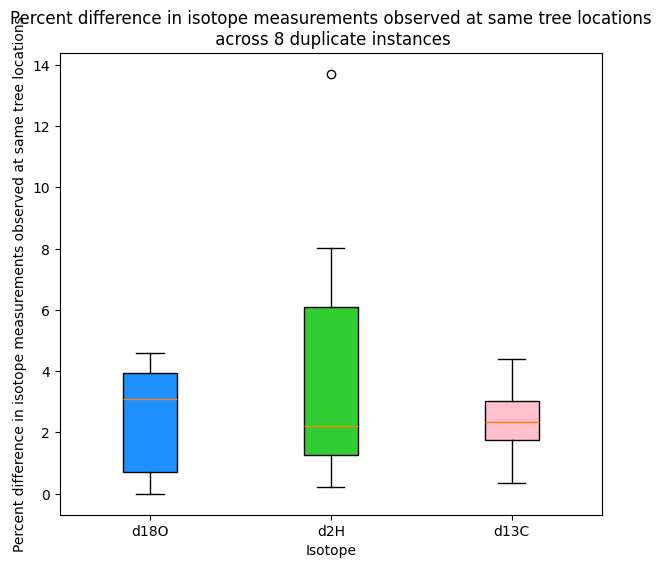

In [85]:

isotopes = df_long_d['Isotope'].unique()
data_to_plot = [df_long_d[df_long_d['Isotope'] == iso]['Range'].values for iso in isotopes]

# Create boxplot
fig, ax = plt.subplots(figsize=(7, 6))
box = ax.boxplot(data_to_plot, patch_artist=True)

# Color each box differently
colors = ['dodgerblue', 'limegreen', 'pink']  
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set x-axis labels
ax.set_xticklabels(isotopes)
ax.grid(False)
ax.set_xlabel("Isotope")
ax.set_title("Percent difference in isotope measurements observed at same tree locations\n across 8 duplicate instances")
ax.set_ylabel("Percent difference in isotope measurements observed at same tree locations")

plt.show()
